# Week 3 Seminar

Collaborative Filtering recommender

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [2]:
DATA_DIR = "/home/nikolay/Documents/made/semester2/recsys-made-2022/data/seminar4/"

In [3]:
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

In [5]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [6]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [7]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [8]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(97263, 39624)

In [9]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [10]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [11]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [11]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2022-06-30 14:39:02,786] A new study created in memory with name: no-name-c9d3265a-c0a0-40a1-b442-cca47ea81771
[I 2022-06-30 14:39:04,074] Trial 0 finished with value: 0.005914478097110987 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.005914478097110987.
[I 2022-06-30 14:39:05,359] Trial 1 finished with value: 0.001650011632591486 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.0001, 'max_sampled': 10, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.005914478097110987.
[I 2022-06-30 14:39:06,657] Trial 2 finished with value: 0.0023936787620186806 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.0001, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.005914478097110987.
[I 2022-06-30 14:39:07,928] Trial 3 finished with value: 0.03184987232089043 and par

[I 2022-06-30 14:39:41,521] Trial 29 finished with value: 0.005914478562772274 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 19 with value: 0.033139668405056.


In [12]:
best_params

{'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 50,
 'user_alpha': 0.0001,
 'item_alpha': 0.0001}

In [13]:
best_params = {'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 20,
 'user_alpha': 0.0,
 'item_alpha': 0.0}

In [14]:
model, precisions_at = fit_model(
    epochs=100,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.01652335748076439 +/- 0.0010617288733474936
1:	0.023332558572292328 +/- 0.0014320883951876703
2:	0.03024633787572384 +/- 0.0017282399118376363
3:	0.030792471021413803 +/- 0.0017366705754199257
4:	0.0317336730659008 +/- 0.001759867532807631
5:	0.0331280492246151 +/- 0.0017821532160112355
6:	0.03426678851246834 +/- 0.0017998148399372526
7:	0.03495235741138458 +/- 0.0018170490827249329
8:	0.03512665629386902 +/- 0.0018131176484965843
9:	0.0355217307806015 +/- 0.0018193981835453394
10:	0.03556820750236511 +/- 0.0018121353802449368
11:	0.036056242883205414 +/- 0.0018289354730585715
12:	0.03631187602877617 +/- 0.001825539878754679
13:	0.03675343096256256 +/- 0.0018309643922084888
14:	0.03707878291606903 +/- 0.0018438565055965785
15:	0.03732280060648918 +/- 0.001843205752879862
16:	0.03769463300704956 +/- 0.0018479832915717692
17:	0.038194283843040466 +/- 0.0018581127755021006
18:	0.03853125870227814 +/- 0.0018682403704550245
19:	0.039077386260032654 +/- 0.0018744116596437408
20:	0.03924

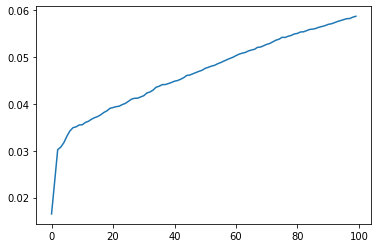

In [15]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [16]:
biases, embeddings = model.get_item_representations()

In [17]:
model.item_biases *= 0.0

In [18]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

ValueError: Expected object or value

In [19]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

NameError: name 'track_meta' is not defined

In [20]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

NameError: name 'dataset_tracks' is not defined

## Compute top recommendations

In [21]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

NameError: name 'dataset_tracks' is not defined

In [22]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

  0%|                                                                                                                                                                                                          | 0/9257 [00:00<?, ?it/s]


TypeError: 'set' object is not subscriptable